In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import xgboost as xgb
import datetime
import operator
from sklearn.cross_validation import train_test_split
from collections import Counter
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from pylab import plot, show, subplot, specgram, imshow, savefig
from sklearn.metrics import log_loss, make_scorer, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

RS = 12357
ROUNDS = 315

print("Started")
np.random.seed(RS)
input_folder = '../kaggle-quora/data/'

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Started


In [2]:
def train_xgb(X, y, params):
    print("Will train XGB for {} rounds, RandomSeed: {}".format(ROUNDS, RS))
    x, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RS)

    xg_train = xgb.DMatrix(x, label=y_train)
    xg_val = xgb.DMatrix(X_val, label=y_val)

    watchlist  = [(xg_train,'train'), (xg_val,'eval')]
    return xgb.train(params, xg_train, ROUNDS, watchlist)

def predict_xgb(clr, X_test):
    return clr.predict(xgb.DMatrix(X_test))

def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
    outfile.close()

def add_word_count(x, df, word):
    x['q1_' + word] = df['question1'].apply(lambda x: (word in str(x).lower())*1)
    x['q2_' + word] = df['question2'].apply(lambda x: (word in str(x).lower())*1)
    x[word + '_both'] = x['q1_' + word] * x['q2_' + word]

In [3]:
# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller

def get_weight(count, eps=10000, min_count=2):
    return 0 if count < min_count else 1 / (count + eps)

def word_shares(row):
    q1_list = str(row['question1']).lower().split()
    q1 = set(q1_list)
    q1words = q1.difference(stops)
    if len(q1words) == 0:
        return '0:0:0:0:0:0:0:0'

    q2_list = str(row['question2']).lower().split()
    q2 = set(q2_list)
    q2words = q2.difference(stops)
    if len(q2words) == 0:
        return '0:0:0:0:0:0:0:0'

    words_hamming = sum(1 for i in zip(q1_list, q2_list) if i[0]==i[1])/max(len(q1_list), len(q2_list))

    q1stops = q1.intersection(stops)
    q2stops = q2.intersection(stops)

    q1_2gram = set([i for i in zip(q1_list, q1_list[1:])])
    q2_2gram = set([i for i in zip(q2_list, q2_list[1:])])

    shared_2gram = q1_2gram.intersection(q2_2gram)

    shared_words = q1words.intersection(q2words)
    shared_weights = [weights.get(w, 0) for w in shared_words]
    q1_weights = [weights.get(w, 0) for w in q1words]
    q2_weights = [weights.get(w, 0) for w in q2words]
    total_weights = q1_weights + q1_weights

    R1 = np.sum(shared_weights) / np.sum(total_weights) #tfidf share
    R2 = len(shared_words) / (len(q1words) + len(q2words) - len(shared_words)) #count share
    R31 = len(q1stops) / len(q1words) #stops in q1
    R32 = len(q2stops) / len(q2words) #stops in q2
    Rcosine_denominator = (np.sqrt(np.dot(q1_weights,q1_weights))*np.sqrt(np.dot(q2_weights,q2_weights)))
    Rcosine = np.dot(shared_weights, shared_weights)/Rcosine_denominator
    if len(q1_2gram) + len(q2_2gram) == 0:
        R2gram = 0
    else:
        R2gram = len(shared_2gram) / (len(q1_2gram) + len(q2_2gram))
    return '{}:{}:{}:{}:{}:{}:{}:{}'.format(R1, R2, len(shared_words), R31, R32, R2gram, Rcosine, words_hamming)

In [4]:
%%time

params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.11
params['max_depth'] = 5
params['silent'] = 1
params['seed'] = RS

df_train = pd.read_csv(input_folder + 'train.csv')
df_test  = pd.read_csv(input_folder + 'test.csv')

print("Original data: X_train: {}, X_test: {}".format(df_train.shape, df_test.shape))
print("Features processing, be patient...")


train_qs = pd.Series(df_train['question1'].tolist() + \
                     df_train['question2'].tolist()).astype(str)
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

stops = set(stopwords.words("english"))


df = pd.concat([df_train, df_test])
df['word_shares'] = df.apply(word_shares, axis=1, raw=True)

Original data: X_train: (404290, 6), X_test: (2345796, 3)
Features processing, be patient...


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in long_scalars


CPU times: user 5min 18s, sys: 6.29 s, total: 5min 24s
Wall time: 5min 40s


In [5]:
%%time

x = pd.DataFrame()

x['word_match']       = df['word_shares'].apply(lambda x: float(x.split(':')[0]))
x['word_match_2root'] = np.sqrt(x['word_match'])
x['tfidf_word_match'] = df['word_shares'].apply(lambda x: float(x.split(':')[1]))
x['shared_count']     = df['word_shares'].apply(lambda x: float(x.split(':')[2]))

x['stops1_ratio']     = df['word_shares'].apply(lambda x: float(x.split(':')[3]))
x['stops2_ratio']     = df['word_shares'].apply(lambda x: float(x.split(':')[4]))
x['shared_2gram']     = df['word_shares'].apply(lambda x: float(x.split(':')[5]))
x['cosine']           = df['word_shares'].apply(lambda x: float(x.split(':')[6]))
x['words_hamming']    = df['word_shares'].apply(lambda x: float(x.split(':')[7]))
x['diff_stops_r']     = x['stops1_ratio'] - x['stops2_ratio']

x['len_q1'] = df['question1'].apply(lambda x: len(str(x)))
x['len_q2'] = df['question2'].apply(lambda x: len(str(x)))
x['diff_len'] = x['len_q1'] - x['len_q2']

x['caps_count_q1'] = df['question1'].apply(lambda x:sum(1 for i in str(x) if i.isupper()))
x['caps_count_q2'] = df['question2'].apply(lambda x:sum(1 for i in str(x) if i.isupper()))
x['diff_caps'] = x['caps_count_q1'] - x['caps_count_q2']

x['len_char_q1'] = df['question1'].apply(lambda x: len(str(x).replace(' ', '')))
x['len_char_q2'] = df['question2'].apply(lambda x: len(str(x).replace(' ', '')))
x['diff_len_char'] = x['len_char_q1'] - x['len_char_q2']

x['len_word_q1'] = df['question1'].apply(lambda x: len(str(x).split()))
x['len_word_q2'] = df['question2'].apply(lambda x: len(str(x).split()))
x['diff_len_word'] = x['len_word_q1'] - x['len_word_q2']

x['avg_world_len1'] = x['len_char_q1'] / x['len_word_q1']
x['avg_world_len2'] = x['len_char_q2'] / x['len_word_q2']
x['diff_avg_word'] = x['avg_world_len1'] - x['avg_world_len2']

x['exactly_same'] = (df['question1'] == df['question2']).astype(int)
x['duplicated'] = df.duplicated(['question1','question2']).astype(int)

CPU times: user 1min 25s, sys: 2.72 s, total: 1min 28s
Wall time: 1min 35s


# Add Magic Features.

In [6]:
%%time

train_combine = pd.read_csv('../kaggle-quora/features/train_magic.csv', header=0)
test_combine = pd.read_csv('../kaggle-quora/features/test_magic.csv', header=0)
df_combine = pd.concat([train_combine, test_combine])
x['q1_freq'] = df_combine['q1_freq']
x['q2_freq'] = df_combine['q2_freq']

CPU times: user 1.04 s, sys: 301 ms, total: 1.34 s
Wall time: 1.45 s


In [27]:
train_combine.shape[0] + test_combine.shape[0]

2750086

# Add Interaction Features.

In [41]:
%%time

train_inter = pd.read_csv('../kaggle-quora/features/train_intersection.csv', header=0)
test_inter = pd.read_csv('../kaggle-quora/features/test_intersection.csv', header=0)
df_combine = pd.concat([train_inter, test_inter])
x['q1_q2_intersect'] = df_combine['q1_q2_intersect']
del df_combine

CPU times: user 227 ms, sys: 76.2 ms, total: 303 ms
Wall time: 304 ms


# Other Features

In [43]:
%%time

add_word_count(x, df,'how')
add_word_count(x, df,'what')
add_word_count(x, df,'which')
add_word_count(x, df,'who')
add_word_count(x, df,'where')
add_word_count(x, df,'when')
add_word_count(x, df,'why')

print(x.columns)
print(x.describe())

Index(['word_match', 'word_match_2root', 'tfidf_word_match', 'shared_count',
       'stops1_ratio', 'stops2_ratio', 'shared_2gram', 'cosine',
       'words_hamming', 'diff_stops_r', 'len_q1', 'len_q2', 'diff_len',
       'caps_count_q1', 'caps_count_q2', 'diff_caps', 'len_char_q1',
       'len_char_q2', 'diff_len_char', 'len_word_q1', 'len_word_q2',
       'diff_len_word', 'avg_world_len1', 'avg_world_len2', 'diff_avg_word',
       'exactly_same', 'duplicated', 'q1_freq', 'q2_freq', 'q1_q2_intersect',
       'q1_how', 'q2_how', 'how_both', 'q1_what', 'q2_what', 'what_both',
       'q1_which', 'q2_which', 'which_both', 'q1_who', 'q2_who', 'who_both',
       'q1_where', 'q2_where', 'where_both', 'q1_when', 'q2_when', 'when_both',
       'q1_why', 'q2_why', 'why_both'],
      dtype='object')
         word_match  word_match_2root  tfidf_word_match  shared_count  \
count  2.744371e+06      2.744371e+06      2.750086e+06  2.750086e+06   
mean   1.542752e-01      3.228801e-01      2.016003e-0

# Oversampling and Train/Test Split

In [44]:
%%time

feature_names = list(x.columns.values)
create_feature_map(feature_names)
print("Features: {}".format(feature_names))

x_train = x[:df_train.shape[0]]
x_test  = x[df_train.shape[0]:]
y_train = df_train['is_duplicate'].values
del x, df_train

if 1: # Now we oversample the negative class - on your own risk of overfitting!
    pos_train = x_train[y_train == 1]
    neg_train = x_train[y_train == 0]

    print("Oversampling started for proportion: {}".format(len(pos_train) / (len(pos_train) + len(neg_train))))
    p = 0.165
    scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
    while scale > 1:
        neg_train = pd.concat([neg_train, neg_train])
        scale -=1
    neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
    print("Oversampling done, new proportion: {}".format(len(pos_train) / (len(pos_train) + len(neg_train))))

    x_train = pd.concat([pos_train, neg_train])
    y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
    del pos_train, neg_train

Features: ['word_match', 'word_match_2root', 'tfidf_word_match', 'shared_count', 'stops1_ratio', 'stops2_ratio', 'shared_2gram', 'cosine', 'words_hamming', 'diff_stops_r', 'len_q1', 'len_q2', 'diff_len', 'caps_count_q1', 'caps_count_q2', 'diff_caps', 'len_char_q1', 'len_char_q2', 'diff_len_char', 'len_word_q1', 'len_word_q2', 'diff_len_word', 'avg_world_len1', 'avg_world_len2', 'diff_avg_word', 'exactly_same', 'duplicated', 'q1_freq', 'q2_freq', 'q1_q2_intersect', 'q1_how', 'q2_how', 'how_both', 'q1_what', 'q2_what', 'what_both', 'q1_which', 'q2_which', 'which_both', 'q1_who', 'q2_who', 'who_both', 'q1_where', 'q2_where', 'where_both', 'q1_when', 'q2_when', 'when_both', 'q1_why', 'q2_why', 'why_both']
Oversampling started for proportion: 0.369197853026293
Oversampling done, new proportion: 0.19124366100096607
CPU times: user 900 ms, sys: 1.21 s, total: 2.11 s
Wall time: 2.15 s


In [45]:
print(type(x_train), '\n')
print(x_train.shape)
print(len(y_train))
x_train.head(2)

<class 'pandas.core.frame.DataFrame'> 

(780486, 51)
780486


,word_match,word_match_2root,tfidf_word_match,shared_count,stops1_ratio,stops2_ratio,shared_2gram,cosine,words_hamming,diff_stops_r,...,who_both,q1_where,q2_where,where_both,q1_when,q2_when,when_both,q1_why,q2_why,why_both
5,0.269175,0.518820,0.307692,4.0,0.875,0.777778,0.100000,0.488688,0.250000,0.097222,...,0,0,0,0,0,0,0,0,0,0
7,0.385400,0.620806,0.333333,1.0,2.500,3.500000,0.071429,0.748695,0.111111,-1.000000,...,0,0,0,0,0,0,0,0,0,0


In [46]:
x_test.head()

,word_match,word_match_2root,tfidf_word_match,shared_count,stops1_ratio,stops2_ratio,shared_2gram,cosine,words_hamming,diff_stops_r,...,who_both,q1_where,q2_where,where_both,q1_when,q2_when,when_both,q1_why,q2_why,why_both
0,0.176680,0.420334,0.153846,2.0,0.833333,0.444444,0.043478,0.287964,0.000000,0.388889,...,0,0,0,0,0,0,0,0,1,0
1,0.212054,0.460493,0.333333,3.0,1.000000,0.400000,0.105263,0.464290,0.142857,0.600000,...,0,0,0,0,0,0,0,0,0,0
2,0.191159,0.437218,0.285714,2.0,1.000000,1.000000,0.055556,0.464872,0.071429,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,0.000000,0.000000,0.000000,0.0,1.000000,0.500000,0.000000,0.000000,0.000000,0.500000,...,0,0,0,0,0,0,0,0,0,0
4,0.500000,0.707107,0.666667,2.0,0.333333,2.000000,0.125000,1.000000,0.166667,-1.666667,...,0,0,0,0,0,0,0,0,0,0


In [47]:
x_train = x_train.fillna(x_train.mean())
x_test = x_test.fillna(x_test.mean())
np.sum(x_test.isnull())

word_match          0
word_match_2root    0
tfidf_word_match    0
shared_count        0
stops1_ratio        0
stops2_ratio        0
shared_2gram        0
cosine              0
words_hamming       0
diff_stops_r        0
len_q1              0
len_q2              0
diff_len            0
caps_count_q1       0
caps_count_q2       0
diff_caps           0
len_char_q1         0
len_char_q2         0
diff_len_char       0
len_word_q1         0
len_word_q2         0
diff_len_word       0
avg_world_len1      0
avg_world_len2      0
diff_avg_word       0
exactly_same        0
duplicated          0
q1_freq             0
q2_freq             0
q1_q2_intersect     0
q1_how              0
q2_how              0
how_both            0
q1_what             0
q2_what             0
what_both           0
q1_which            0
q2_which            0
which_both          0
q1_who              0
q2_who              0
who_both            0
q1_where            0
q2_where            0
where_both          0
q1_when   

# Save the features.

In [ ]:
%%time

pd.to_pickle(x_train, "./train_oversamp_jaccard_magic_intersection_features.pkl")
pd.to_pickle(x_test, "./test_oversamp_jaccard_magic_intersection_features.pkl")

x_train.to_csv('./train_oversamp_jaccard_magic_intersection_features.csv')
x_test.to_csv('./test_oversamp_jaccard_magic_intersection_features.csv')

pd.DataFrame(data=y_train).to_csv('./y_train_oversampled.csv', index=False)

# Prepare for 5 fold stacking

In [24]:
### For piping data directly from above ###

from sklearn.model_selection import StratifiedKFold, GridSearchCV

skf = StratifiedKFold(n_splits=3, random_state=None)
folds = skf.split(x_train, y_train)
_, fold1_index = next(folds)
_, fold2_index = next(folds)
_, validation_index = next(folds)

# pd.DataFrame(data=fold1_index).to_csv('./fold1_index.csv', index=False)
# pd.DataFrame(data=fold2_index).to_csv('./fold2_index.csv', index=False)
# pd.DataFrame(data=validation_index).to_csv('./validation_index.csv', index=False)

print(fold1_index.shape)
print(fold2_index.shape)
print(validation_index.shape)

train_fold1 = x_train.iloc[fold1_index, :]
train_fold2 = x_train.iloc[fold2_index, :]
validation_fold = x_train.iloc[validation_index, :]

y_train_fold1 = pd.DataFrame(data=y_train).iloc[fold1_index, :]
y_train_fold2 = pd.DataFrame(data=y_train).iloc[fold2_index, :]
y_validation_fold = pd.DataFrame(data=y_train).iloc[validation_index, :]

In [175]:
#####################################
### Use this cell if loading data ###
#####################################


# x_train = pd.read_csv('../kaggle-quora/features/train_oversamp_jaccard_magic_features.csv').drop('Unnamed: 0', axis=1)
# y_train = pd.read_csv('../kaggle-quora/features/y_train_oversampled.csv')
# x_test = pd.read_csv('../kaggle-quora/features/test_oversamp_jaccard_magic_features.csv').drop('Unnamed: 0', axis=1)
# x_test_index = pd.read_csv('../kaggle-quora/features/test_oversamp_jaccard_magic_features.csv').index.values

fold1_index = pd.read_csv('./index/fold1_index.csv')
fold2_index = pd.read_csv('./index/fold2_index.csv')
validation_index = pd.read_csv('./index/validation_index.csv')

train_fold1 = x_train.iloc[fold1_index.values.flatten(), :]
train_fold2 = x_train.iloc[fold2_index.values.flatten(), :]
validation_fold = x_train.iloc[validation_index.values.flatten(), :]

y_train_fold1 = pd.DataFrame(y_train).iloc[fold1_index.values.flatten(), :]
y_train_fold2 = pd.DataFrame(y_train).iloc[fold2_index.values.flatten(), :]
y_validation_fold = pd.DataFrame(y_train).iloc[validation_index.values.flatten(), :]

# train_stack = pd.concat((train_fold1, train_fold2), axis=0)
# y_train_stack = pd.concat((y_train_fold1, y_train_fold2), axis=0)
# train_stack.shape

print(y_train_fold1[0].value_counts())
print(y_train_fold2[0].value_counts())
print(y_validation_fold[0].value_counts())

0.0    210408
1.0     49755
Name: 0, dtype: int64
0.0    210408
1.0     49754
Name: 0, dtype: int64
0.0    210407
1.0     49754
Name: 0, dtype: int64


In [86]:
#####################################
# Generate 5 Fold Stacking Features #
#####################################

from sklearn.model_selection import StratifiedKFold, validation_curve, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

def five_fold_train(x, y, model, name='model', folds=5):
    ''' Function for Generate Five Fold Stacking Features '''
#     x_train_scaled = MinMaxScaler().fit_transform(x)
    x_train_scaled = x
    skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

    fold_count = 1
    for train_index, val_index in skf.split(x_train_scaled, y.toarray().flatten()):
        print('Folds: ', fold_count)
        
        # Training...
        model.fit(x_train_scaled[train_index], y[train_index].toarray().flatten())
        train_error = model.predict_proba(x_train_scaled[train_index])
        train_error = pd.DataFrame(train_error).drop(0, axis=1)

        # Validating. Layer 2 training features...
        val = model.predict_proba(x_train_scaled[val_index])
        val = pd.DataFrame(val).drop(0, axis=1)
        y_val = y[val_index].toarray().flatten()

        val.to_csv('./{}_fold_{}.csv'.format(name, fold_count))
        pd.DataFrame(y_val).to_csv('./{}_yval_fold_{}.csv'.format(name, fold_count)) # For sanity check.
        print(val.head())
        print('Training Error: ', log_loss(y[train_index].toarray().flatten(), train_error))
        print('Validation Error: ', log_loss(y_val, val))
        fold_count = fold_count + 1

# Logistic Regression

In [77]:
%%time 

###########################
### Logistic Regression ###
###########################

from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(penalty='l2', solver='sag')
x_train_scaled = MinMaxScaler().fit_transform(x_train)
train_scores, valid_scores = validation_curve(logit, \
                                              x_train_scaled, \
                                              y_train, \
                                              "C", \
                                              range(5, 18, 2), \
                                              cv=3, \
                                              scoring='neg_log_loss', \
                                              n_jobs=1)

CPU times: user 9min 59s, sys: 12.2 s, total: 10min 11s
Wall time: 10min 17s


In [ ]:
%%time

logit = LogisticRegression(penalty='l1', solver='liblinear')
logit_params = {'C':[0.1, 0.5, 0.9]}
logit_grid = GridSearchCV(logit, \
                          logit_params, \
                          scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True), \
                          cv=5, \
                          verbose=10)
logit_grid.fit(x_train, y_train)

print('Params: ', logit_grid.cv_results_['params'])
print('Mean Train Score: ', logit_grid.cv_results_['mean_train_score'])
print('Mean Test Score: ', logit_grid.cv_results_['mean_test_score'])
print('Best Param: ', logit_grid.best_params_)
print('Best Score: ', logit_grid.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] C=0.1 ...........................................................


In [92]:
Params:  ({'C': 1}, {'C': 10}, {'C': 100}, {'C': 1000})
Mean Train Score:  [-0.2665898  -0.26658942 -0.26658964 -0.26658882]
Mean Test Score:  [-0.2666143  -0.26661384 -0.26661411 -0.26661329]
Best Param:  {'C': 1000}
Best Score:  -0.266613293055

##############################
Params:  ({'C': 500}, {'C': 1000}, {'C': 1500}, {'C': 2000})
Mean Train Score:  [-0.26658964 -0.26658987 -0.2665897  -0.26658974]
Mean Test Score:  [-0.26661406 -0.2666143  -0.26661417 -0.2666142 ]
Best Param:  {'C': 500}
Best Score:  -0.266614057533

##############################
Params:  ({'C': 1, 'penalty': 'l1'}, {'C': 1, 'penalty': 'l2'}, {'C': 100, 'penalty': 'l1'}, {'C': 100, 'penalty': 'l2'}, {'C': 1000, 'penalty': 'l1'}, {'C': 1000, 'penalty': 'l2'})
Mean Train Score:  [-0.24746581 -0.24778714 -0.24748284 -0.24754584 -0.247478   -0.24755111]
Mean Test Score:  [-0.24752209 -0.24784375 -0.24753546 -0.2476028  -0.24752787 -0.2475922 ]
Best Param:  {'C': 1, 'penalty': 'l1'}
Best Score:  -0.247522085005

Params:  ({'C': 1}, {'C': 10}, {'C': 100}, {'C': 1000})
Mean Train Score:  [-0.2665898  -0.26658942 -0.26658964 -0.26658882]
Mean Test Score:  [-0.2666143  -0.26661384 -0.26661411 -0.26661329]
Best Param:  {'C': 1000}
Best Score:  -0.266613293055


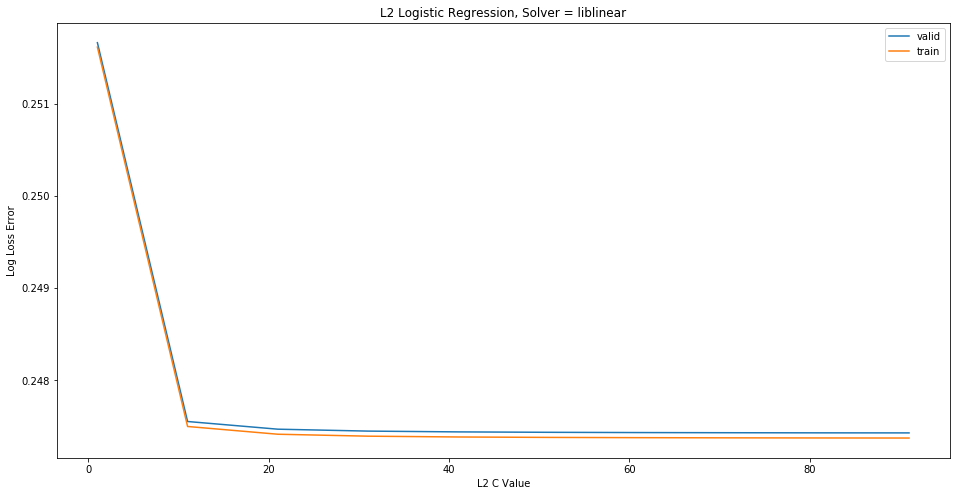

In [75]:
valid_scores_mean = -1*np.mean(valid_scores, axis=1)
train_scores_mean = -1*np.mean(train_scores, axis=1)

plt.figure(figsize=(16, 8))
plt.plot(range(5, 18, 2), valid_scores_mean, label='valid')
plt.plot(range(5, 18, 2), train_scores_mean, label='train')
plt.title('L2 Logistic Regression, Solver = liblinear')

plt.xlabel('L2 C Value')
plt.ylabel('Log Loss Error')
plt.legend()

In [40]:
%%time
logit = LogisticRegression(solver='sag', C=1)
five_fold_train(x_train, y_train, logit, name='logit', folds=5)

Folds:  1


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


          1
0  0.140120
1  0.674630
2  0.352436
3  0.806241
4  0.733487
Training Error:  0.181013578451
Validation Error:  0.219938991821
Folds:  2
          1
0  0.682919
1  0.506382
2  0.489184
3  0.802108
4  0.725015
Training Error:  0.177402226438
Validation Error:  0.233067737294
Folds:  3
          1
0  0.872292
1  0.855754
2  0.946933
3  0.579891
4  0.881219
Training Error:  0.180767232494
Validation Error:  0.220788973166
Folds:  4
          1
0  0.192511
1  0.517579
2  0.864140
3  0.676547
4  0.608767
Training Error:  0.177274701256
Validation Error:  0.23404859658
Folds:  5
          1
0  0.203961
1  0.273272
2  0.369178
3  0.942537
4  0.633795
Training Error:  0.180871739442
Validation Error:  0.220228106791
CPU times: user 18min 14s, sys: 17.3 s, total: 18min 32s
Wall time: 18min 58s


In [43]:
%%time

# Training on the whole training set, and predict on test set. Used as test feature for stacking.
logit = LogisticRegression(penalty='l2', solver='sag', C=15)
logit.fit(x_train, y_train.toarray().flatten())
logit_layer_1_test = logit.predict_proba(x_test)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CPU times: user 4min 3s, sys: 1.54 s, total: 4min 4s
Wall time: 4min 5s


In [44]:
x_test_index = pd.read_csv('../kaggle-quora/features/test_oversamp_jaccard_magic_features.csv').index.values
submission = pd.DataFrame()
submission['test_id'] = x_test_index
submission['is_duplicate'] = pd.DataFrame(logit_layer_1_test)[1]
submission.to_csv('logit_layer_1_test_sparse_data_l2_sag_C1.csv', index=False)

In [178]:
%%time

# If already scaled, comment out:
# scaler = MinMaxScaler()
# train_fold1_scaled = scaler.fit_transform(train_fold1)
# train_fold2_scaled = scaler.fit_transform(train_fold2)
# validation_fold_scaled = scaler.fit_transform(validation_fold)

# If already scaled, use this:
train_fold1_scaled = train_fold1
train_fold2_scaled = train_fold2
validation_fold_scaled = validation_fold

def get_2fold_stack_logit(model):
    model.fit(train_fold1_scaled, y_train_fold1)
    new_fold2 = model.predict_proba(train_fold2_scaled)
    v1 = model.predict_proba(validation_fold_scaled)  ### There is model

    model.fit(train_fold2_scaled, y_train_fold2)
    new_fold1 = model.predict_proba(train_fold1_scaled)
    v2 = model.predict_proba(validation_fold_scaled) ### The model here is different
    
    return np.concatenate([new_fold1, new_fold2], axis=0), (v1+v2)/2

logit = LogisticRegression(verbose=10)
logit_layer_1_train, logit_layer_1_val = get_2fold_stack_logit(logit)
print('\nThe log loss is: %.3f' % log_loss(y_validation_fold, logit_layer_1_val))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear][LibLinear]The log loss is: 0.351
CPU times: user 33.2 s, sys: 511 ms, total: 33.7 s
Wall time: 34 s


In [121]:
%%time

##############################
### RandomForestClassifier ###
##############################

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50, max_depth=8, min_samples_leaf=5)
x_train_scaled = MinMaxScaler().fit_transform(x_train)
train_scores, valid_scores = validation_curve(rf, \
                                              x_train_scaled, \
                                              y_train, \
                                              "min_samples_leaf", \
                                              range(1, 9, 2), \
                                              cv=3, \
                                              scoring='neg_log_loss', \
                                              n_jobs=1)

CPU times: user 12min 48s, sys: 17.5 s, total: 13min 6s
Wall time: 14min 51s


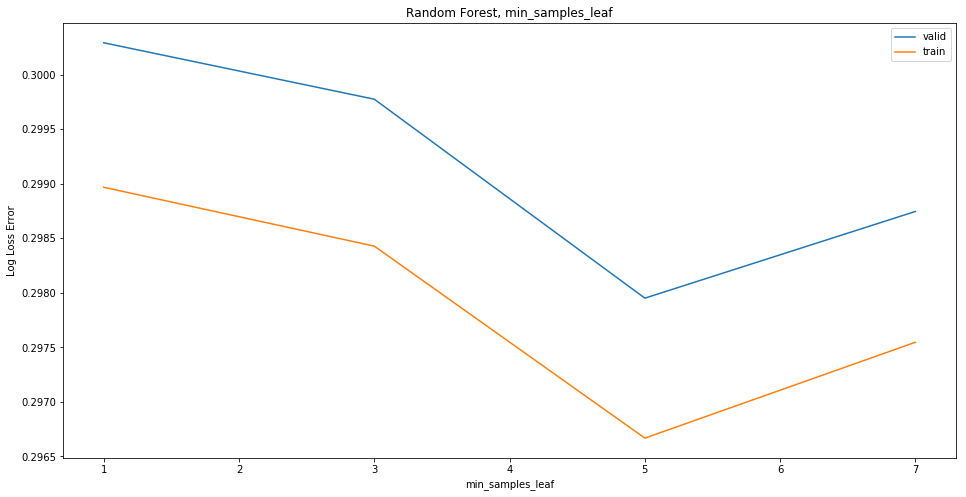

In [122]:
# Plot the learning curve from the above result.

valid_scores_mean = -1*np.mean(valid_scores, axis=1)
train_scores_mean = -1*np.mean(train_scores, axis=1)

plt.figure(figsize=(16, 8))
plt.plot(range(1, 9, 2), valid_scores_mean, label='valid')
plt.plot(range(1, 9, 2), train_scores_mean, label='train')
plt.title('Random Forest, min_samples_leaf')

plt.xlabel('min_samples_leaf')
plt.ylabel('Log Loss Error')
plt.legend()

In [36]:
%%time
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50, max_depth=8, min_samples_leaf=5)
five_fold_train(x_train, y_train, rf, name='rf', folds=5)

Folds:  1


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


          1
0  0.093955
1  0.810183
2  0.118173
3  0.980945
4  0.863885
Training Error:  0.0589571743837
Validation Error:  0.162301475883
Folds:  2
          1
0  0.362710
1  0.862683
2  0.556769
3  0.969548
4  0.952394
Training Error:  0.0575317995721
Validation Error:  0.172268231372
Folds:  3
          1
0  0.966553
1  0.968087
2  0.997220
3  0.665508
4  0.992391
Training Error:  0.0588350491621
Validation Error:  0.163564177422
Folds:  4
          1
0  0.107062
1  0.509644
2  0.983645
3  0.853696
4  0.966892
Training Error:  0.0574649957295
Validation Error:  0.173630240822
Folds:  5
          1
0  0.304482
1  0.539709
2  0.620212
3  0.994627
4  0.809528
Training Error:  0.0588546954903
Validation Error:  0.162709384984
CPU times: user 16min 2s, sys: 8.55 s, total: 16min 11s
Wall time: 16min 12s


In [184]:
%%time

def get_2fold_stack_rf(model):
    ''' Get 2 fold stacking results '''
    model.fit(train_fold1_scaled, y_train_fold1)
    new_fold2 = model.predict_proba(train_fold2_scaled)
    v1 = model.predict_proba(validation_fold_scaled)  ### There is model

    model.fit(train_fold2_scaled, y_train_fold2)
    new_fold1 = model.predict_proba(train_fold1_scaled)
    v2 = model.predict_proba(validation_fold_scaled) ### The model here is different
    
    return np.concatenate([new_fold1, new_fold2], axis=0), (v1+v2)/2

rf = RandomForestClassifier(n_estimators=150)
rf_layer_1_train, rf_layer_1_val = get_2fold_stack_rf(rf)

rf_layer_1_val = pd.DataFrame(rf_layer_1_val).drop(0, axis=1)
rf_layer_1_val.columns = ['rf_layer_1_val']

rf_layer_1_train = pd.DataFrame(rf_layer_1_train).drop(0, axis=1)
rf_layer_1_train.columns = ['rf_layer_1_train']

print(log_loss(y_validation_fold, rf_layer_1_val))
print(log_loss(pd.concat([y_train_fold1, y_train_fold2], axis=0), rf_layer_1_train))

# Output layer 1 folds to csv
# rf_layer_1_train.to_csv('./rf_layer_1_train.csv', index=False)
# rf_layer_1_val.to_csv('./rf_layer_1_val.csv', index=False)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.19647339767
0.201647508498
CPU times: user 4min 29s, sys: 5.09 s, total: 4min 34s
Wall time: 4min 38s


In [38]:
%%time

# Training on the whole training set, and predict on test set. Used as test feature for stacking.
rf = RandomForestClassifier(n_estimators=50, max_depth=8, min_samples_leaf=5)
rf.fit(x_train, y_train.toarray().flatten())
rf_layer_1_test = rf.predict_proba(x_test)

CPU times: user 1min 46s, sys: 4.11 s, total: 1min 50s
Wall time: 1min 51s


In [39]:
x_test_index = pd.read_csv('../kaggle-quora/features/test_oversamp_jaccard_magic_features.csv').index.values

submission = pd.DataFrame()
submission['test_id'] = x_test_index
submission['is_duplicate'] = pd.DataFrame(rf_layer_1_test)[1]
submission.to_csv('rf_layer_1_test_sparse_50_8_5.csv', index=False)

In [65]:
print(x_train.shape, len(y_train), x_test.shape)
y_train[1:10]
type(np.array(y_train))

(780486, 51) 780486 (2345796, 51)


numpy.ndarray

# XGBoost

In [66]:
###############
### XGBoost ###
###############

def five_fold_train_xgb(x, y, param, rounds, model, name='model', folds=5):
    ''' Function for Generate Five Fold Stacking Features '''
    x_train_scaled = MinMaxScaler().fit_transform(x)    
    skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

    fold_count = 1
    for train_index, val_index in skf.split(x_train_scaled, y):
        print('Folds: ', fold_count)

        # Preparing Data...
        xg_train = xgb.DMatrix(x_train_scaled[train_index], label=y[train_index])
        xg_val = xgb.DMatrix(x_train_scaled[val_index], label=y[val_index])
        watchlist = [(xg_train, 'train'), (xg_val, 'eval')]
        
        # Training...
        clf = model.train(param, \
                          xg_train, \
                          rounds, \
                          watchlist, \
                          early_stopping_rounds=10, \
                          verbose_eval=10)
        
        
        # Validating. Layer 2 training features...
        xg_val_2 = xgb.DMatrix(x_train_scaled[val_index])
        val = clf.predict(xg_val_2)
        val = pd.DataFrame(val)
        y_val = y[val_index]

        val.to_csv('./{}_fold_{}.csv'.format(name, fold_count))
        pd.DataFrame(y_val).to_csv('./{}_yval_fold_{}.csv'.format(name, fold_count)) # For sanity check.
        print(val.head())
        print('Validation Error: ', log_loss(y_val, val))
        fold_count = fold_count + 1
        
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.11
params['max_depth'] = 5
params['seed'] = RS

In [67]:
%%time
five_fold_train_xgb(x_train, np.array(y_train), params, 1000, xgb, 'xgb', 5)

Folds:  1
[0]	train-logloss:0.619098	eval-logloss:0.619159
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.315375	eval-logloss:0.315684
[20]	train-logloss:0.245995	eval-logloss:0.2464
[30]	train-logloss:0.224195	eval-logloss:0.224654
[40]	train-logloss:0.216184	eval-logloss:0.21683
[50]	train-logloss:0.211939	eval-logloss:0.212651
[60]	train-logloss:0.208865	eval-logloss:0.209684
[70]	train-logloss:0.206421	eval-logloss:0.207267
[80]	train-logloss:0.204765	eval-logloss:0.205721
[90]	train-logloss:0.203241	eval-logloss:0.204362
[100]	train-logloss:0.20192	eval-logloss:0.203164
[110]	train-logloss:0.200951	eval-logloss:0.202323
[120]	train-logloss:0.200054	eval-logloss:0.201577
[130]	train-logloss:0.199153	eval-logloss:0.200769
[140]	train-logloss:0.198432	eval-logloss:0.200181
[150]	train-logloss:0.197675	eval-logloss:0.199578
[160]	train-logloss:0.196935	eval-loglos

KeyboardInterrupt: 

In [82]:
%%time

# Do CV to check train/validation curve.

params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.11
params['max_depth'] = 5
params['seed'] = RS

d_train = xgb.DMatrix(x_train, label=y_train)
model_cv = xgb.cv(params, \
                  d_train, \
                  2500, \
                  nfold=3, \
                  metrics='logloss', \
                  early_stopping_rounds=10, \
                  verbose_eval=10)

[0]	train-logloss:0.477555+0.000418674	test-logloss:0.477572+0.000829721
[10]	train-logloss:0.40089+0.000371792	test-logloss:0.401076+0.000693702
[20]	train-logloss:0.353104+0.000322314	test-logloss:0.353459+0.000684774
[30]	train-logloss:0.319786+0.000320911	test-logloss:0.3203+0.000682732
[40]	train-logloss:0.29531+0.000291169	test-logloss:0.295969+0.000701328
[50]	train-logloss:0.276728+0.000290223	test-logloss:0.277525+0.00071075
[60]	train-logloss:0.262275+0.000268025	test-logloss:0.263212+0.000742039
[70]	train-logloss:0.251016+0.000262604	test-logloss:0.252095+0.000745416
[80]	train-logloss:0.242083+0.00025898	test-logloss:0.243295+0.0007375
[90]	train-logloss:0.234987+0.000254864	test-logloss:0.236331+0.000747171
[100]	train-logloss:0.229271+0.000256697	test-logloss:0.230731+0.000744738
[110]	train-logloss:0.224637+0.000274465	test-logloss:0.226221+0.000717951
[120]	train-logloss:0.220889+0.000283192	test-logloss:0.222587+0.000704571
[130]	train-logloss:0.217798+0.000274141	tes

[1100]	train-logloss:0.175849+0.000291761	test-logloss:0.190344+0.000672822
[1110]	train-logloss:0.17565+0.000310413	test-logloss:0.190272+0.000662131
[1120]	train-logloss:0.175444+0.000300867	test-logloss:0.190193+0.000660573
[1130]	train-logloss:0.175264+0.00031444	test-logloss:0.190128+0.000662391
[1140]	train-logloss:0.17505+0.00030786	test-logloss:0.190047+0.000664623
[1150]	train-logloss:0.174839+0.000309601	test-logloss:0.189969+0.00066543
[1160]	train-logloss:0.174631+0.000329153	test-logloss:0.189894+0.000657419
[1170]	train-logloss:0.174412+0.000335894	test-logloss:0.189813+0.00064959
[1180]	train-logloss:0.174212+0.000325126	test-logloss:0.189738+0.000647974
[1190]	train-logloss:0.174021+0.000307013	test-logloss:0.189664+0.000644278
[1200]	train-logloss:0.17382+0.000334136	test-logloss:0.189601+0.000634678
[1210]	train-logloss:0.173629+0.000329057	test-logloss:0.189532+0.000644943
[1220]	train-logloss:0.173427+0.000346529	test-logloss:0.189457+0.000636164
[1230]	train-loglos

[2190]	train-logloss:0.156384+0.000356139	test-logloss:0.183829+0.000627629
[2200]	train-logloss:0.156235+0.000334848	test-logloss:0.183788+0.000636267
[2210]	train-logloss:0.156051+0.000339168	test-logloss:0.183734+0.000634515
[2220]	train-logloss:0.155875+0.000335611	test-logloss:0.183682+0.000631362
[2230]	train-logloss:0.155721+0.000334758	test-logloss:0.183637+0.000629544
[2240]	train-logloss:0.155555+0.000315922	test-logloss:0.183584+0.000635311
[2250]	train-logloss:0.155425+0.000312369	test-logloss:0.183545+0.000636736
[2260]	train-logloss:0.155269+0.000304804	test-logloss:0.183496+0.000643294
[2270]	train-logloss:0.155127+0.000308938	test-logloss:0.183461+0.0006439
[2280]	train-logloss:0.154979+0.00029781	test-logloss:0.183419+0.000649744
[2290]	train-logloss:0.15482+0.000306302	test-logloss:0.183371+0.000645589
[2300]	train-logloss:0.154679+0.000306217	test-logloss:0.183332+0.000645589
[2310]	train-logloss:0.154529+0.000307426	test-logloss:0.183286+0.000639175
[2320]	train-log

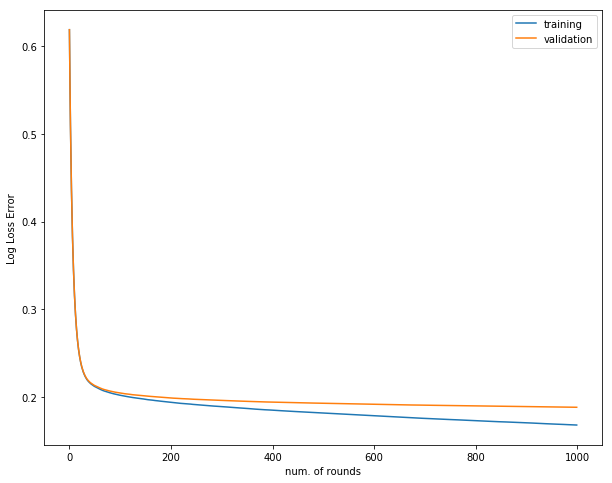

In [70]:
plt.figure(figsize=(10,8))
plt.plot(model_cv['train-logloss-mean'], label='training')
plt.plot(model_cv['test-logloss-mean'], label='validation')
# plt.xlim(200, 400)
# plt.ylim(0.3, 0.38)
plt.xlabel('num. of rounds')
plt.ylabel('Log Loss Error')
plt.legend()
plt.show()

In [84]:
%%time

# Train the model on whole training set and predict on test set.

params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.11
params['max_depth'] = 5
params['seed'] = RS

xg_train_ = xgb.DMatrix(x_train, label=y_train)
xg_test = xgb.DMatrix(x_test)

clf = xgb.train(params, xg_train_, 2500)
xgb_layer_1_test = clf.predict(xg_test)

CPU times: user 5h 7min 49s, sys: 2min 1s, total: 5h 9min 50s
Wall time: 1h 54min 36s


In [85]:
print(type(xgb_layer_1_test))
print(xgb_layer_1_test.shape)
submission = pd.DataFrame()
submission['test_id'] = x_test.index.values
submission['is_duplicate'] = pd.DataFrame(xgb_layer_1_test)
submission.to_csv('./xgb_layer_1_test_jaccard_magic_intersection_0.02_7_0.6_0.2_2500.csv', index=False)

<class 'numpy.ndarray'>
(2345796,)


# Factorization Machine

In [3]:
##########################
### Factorized Machine ###
## Don't Run on Python3 ##
##########################

from sklearn.preprocessing import MinMaxScaler
from scipy import sparse
from scipy.sparse import csc_matrix
# from fastFM import sgd, mcmc
# from fastFM.datasets import make_user_item_regression


train_fold1 = sparse.load_npz("../kaggle-quora/fm/x_train_fold1.npz")
train_fold2 = sparse.load_npz("../kaggle-quora/fm/x_train_fold2.npz")
validation_fold = sparse.load_npz("../kaggle-quora/fm/x_validation_fold.npz")

y_train_fold1 = sparse.load_npz("../kaggle-quora/fm/y_train_fold1.npz")
y_train_fold2 = sparse.load_npz("../kaggle-quora/fm/y_train_fold2.npz")
y_validation_fold = sparse.load_npz("../kaggle-quora/fm/y_validation_fold.npz")

x_test = sparse.load_npz('../kaggle-quora/fm/x_test.npz')

x_train = sparse.vstack((train_fold1, train_fold2, validation_fold), format='csr')
y_train = sparse.hstack((y_train_fold1, y_train_fold2, y_validation_fold), format='csr').T

In [234]:
y_labels_1 = np.ones_like(y_train_fold1.toarray().flatten())
y_labels_1[y_train_fold1.toarray().flatten() < \
         np.mean(y_train_fold1.toarray().flatten())] = -1

y_labels_2 = np.ones_like(y_train_fold2.toarray().flatten())
y_labels_2[y_train_fold2.toarray().flatten() < \
         np.mean(y_train_fold2.toarray().flatten())] = -1

print(pd.Series(data=y_train_fold1.toarray().flatten()).value_counts())
print(pd.Series(data=y_labels_1.flatten()).value_counts())

print(pd.Series(data=y_train_fold2.toarray().flatten()).value_counts())
print(pd.Series(data=y_labels_2.flatten()).value_counts())

0.0    210408
1.0     49755
dtype: int64
-1.0    210408
 1.0     49755
dtype: int64


In [223]:
%%time

# Testing out once for 10 iterations
fm_mcmc = mcmc.FMClassification(n_iter=10, init_stdev=0.1, rank=2)
v1 = fm_mcmc.fit_predict_proba( \
                        train_fold1, \
                        y_labels, \
                        validation_fold)

print(log_loss(y_validation_fold.toarray().flatten(), v1))

0.328760766377
CPU times: user 34.4 s, sys: 1.2 s, total: 35.6 s
Wall time: 35.9 s


In [236]:
%%time

# Running loops to see which iteration is the best
iter_ = []
val = []
for i in range(5, 100, 10):
    fm_mcmc = mcmc.FMClassification(n_iter=i, init_stdev=0.2, rank=2)
    v1 = fm_mcmc.fit_predict_proba( \
                            train_fold1, \
                            y_labels, \
                            validation_fold)
    val.append(log_loss(y_validation_fold.toarray().flatten(), v1))
    iter_.append(i)
    print('Iteration: ', i, ' Loss: ', log_loss(y_validation_fold.toarray().flatten(), v1))

0.342205775173
0.299749623459
0.289569009603
0.282120152275
0.2758567235
0.27235304171
0.271188751078
0.271352077988
0.272389498597
0.273996707593
CPU times: user 28min 55s, sys: 49.7 s, total: 29min 45s
Wall time: 30min 9s


In [ ]:
fm_mcmc = mcmc.FMClassification(n_iter=65, init_stdev=0.2, rank=2)

def get_2fold_stack_fm(model):
    new_fold2 = model.fit_predict_proba(train_fold1, y_labels_1, train_fold2)
    v1 = model.fit_predict_proba(train_fold1, y_labels_1, validation_fold)

    new_fold1 = model.fit_predict_proba(train_fold2, y_labels_2, train_fold1)
    v2 = model.fit_predict_proba(train_fold2, y_labels_2, , validation_fold)
    
    return np.concatenate([new_fold1, new_fold2], axis=0), (v1+v2)/2

fm_layer_1_train, fm_layer_1_val = get_2fold_stack_fm(fm_mcmc)

In [150]:
## init_stdev=0.1
# 1000: 1.15399749209
# 50: 0.56506675468
# 40: 0.550740405848
# 30: 0.532731172364
# 20: 0.508590319759
# 10: 0.475458635038
#  5: 0.461409370446
#  1: 0.499387875638
#  2: 0.475378806541

## init_stdev=0.1
# 1: 0.499387875638
# 0.475378806541
# 0.465276038171
# 0.461566196122
# 0.461409370446
# 0.462968413607
# 0.465514660366
# 0.468569391545
# 10: 0.471916744151

## init_stdev=0.2
# 1: 0.496984050114
# 0.468517078201
# 0.457513158113
# 0.454882109759
# 0.456398071603
# 0.460213356455
# 0.465297675869
# 0.470731505954
# 10: 0.476281348052

0.475378806541


# Training XGBoost

In [27]:
print("Training data: X_train: {}, Y_train: {}, X_test: {}".format(x_train.shape, len(y_train), x_test.shape))
clr = train_xgb(x_train, y_train, params)
preds = predict_xgb(clr, x_test)

Training data: X_train: (780486, 50), Y_train: 780486, X_test: (2345796, 50)
Will train XGB for 315 rounds, RandomSeed: 12357
[0]	train-logloss:0.629423	eval-logloss:0.629526
[1]	train-logloss:0.578195	eval-logloss:0.578343
[2]	train-logloss:0.536378	eval-logloss:0.53656
[3]	train-logloss:0.501217	eval-logloss:0.501432
[4]	train-logloss:0.4719	eval-logloss:0.472147
[5]	train-logloss:0.446716	eval-logloss:0.446973
[6]	train-logloss:0.425318	eval-logloss:0.425612
[7]	train-logloss:0.40699	eval-logloss:0.407314
[8]	train-logloss:0.391354	eval-logloss:0.391734
[9]	train-logloss:0.376584	eval-logloss:0.37698
[10]	train-logloss:0.364227	eval-logloss:0.364643
[11]	train-logloss:0.354132	eval-logloss:0.354596
[12]	train-logloss:0.344738	eval-logloss:0.345218
[13]	train-logloss:0.336595	eval-logloss:0.337109
[14]	train-logloss:0.328956	eval-logloss:0.329458
[15]	train-logloss:0.322348	eval-logloss:0.322837
[16]	train-logloss:0.316893	eval-logloss:0.317378
[17]	train-logloss:0.311979	eval-loglos

Writing output...
Features importances...


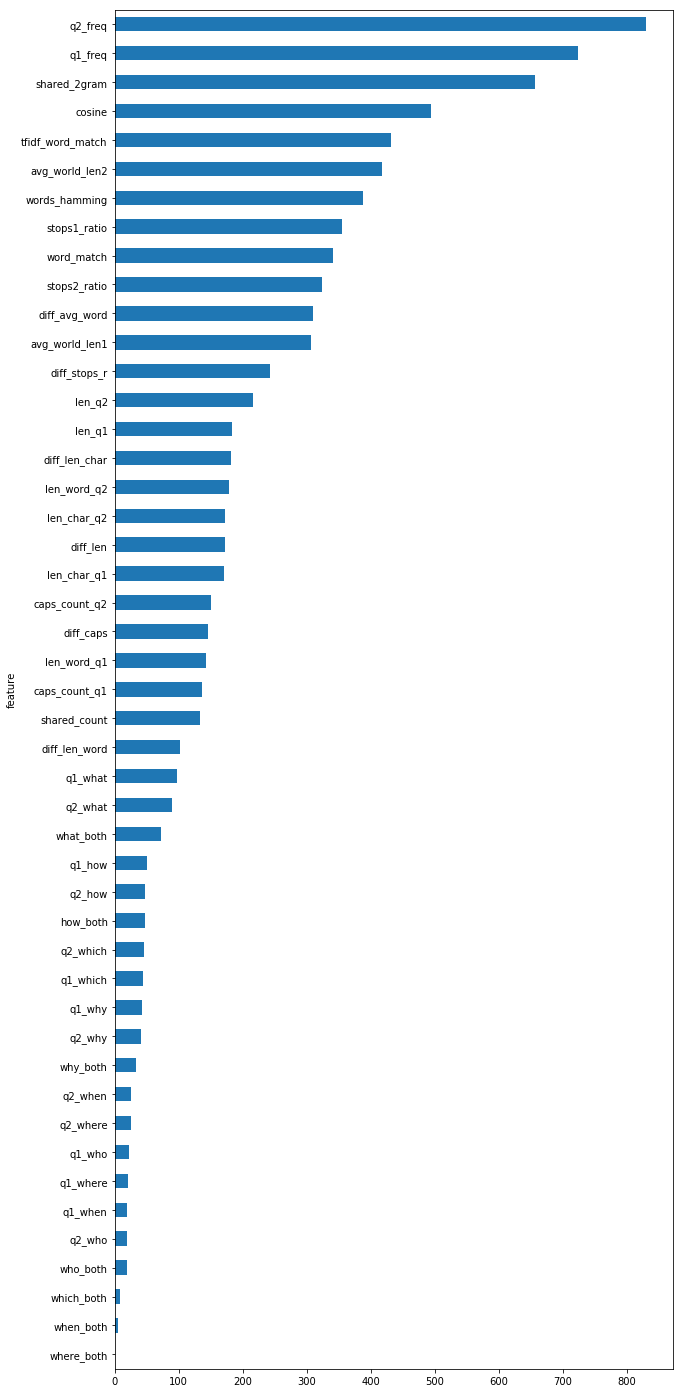

In [30]:
print("Writing output...")
sub = pd.DataFrame()
sub['test_id'] = df_test['test_id']
sub['is_duplicate'] = preds *.75
sub.to_csv("xgb_seed{}_n{}.csv".format(RS, ROUNDS), index=False)

print("Features importances...")
importance = clr.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))
ft = pd.DataFrame(importance, columns=['feature', 'fscore'])

ft.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 25))
plt.gcf().savefig('features_importance.png')